# Functional Connectivity analysis

## Setup

In [48]:
import numpy as np 
import nibabel as nib
import nilearn
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiLabelsMasker
from nilearn.maskers import NiftiSpheresMasker
from nilearn import datasets
from nilearn import plotting
from nilearn.plotting import plot_connectome
from nilearn import interfaces
from nilearn import image


from pathlib import Path

In [49]:
### set working directory (depending on where files are)

os.getcwd() 
root = os.getcwd()
root

# for pilot analysis

root = os.chdir('c:\\Users\\julia\\Desktop\\Leiden first year\\Internship_Synthesis\\Data\\Pilot data\\Pilot_data_BIDS')



os.getcwd() 
root = os.getcwd()
root

'c:\\Users\\julia\\Desktop\\Leiden first year\\Internship_Synthesis\\Data\\Pilot data\\Pilot_data_BIDS'

## Setup atlas + labels 

### Schaefer_2018 atlas

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 50, 51, 52, 53, 54, 55, 56, 57], [9, 10, 11, 12, 13, 14, 58, 59, 60, 61, 62, 63, 64, 65], [15, 16, 17, 18, 19, 20, 21, 22, 66, 67, 68, 69, 70, 71, 72], [23, 24, 25, 26, 27, 28, 29, 73, 74, 75, 76, 77], [30, 31, 32, 78, 79], [33, 34, 35, 36, 80, 81, 82, 83, 84, 85, 86, 87, 88], [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]
{'Vis': [0, 1, 2, 3, 4, 5, 6, 7, 8, 50, 51, 52, 53, 54, 55, 56, 57], 'SomMot': [9, 10, 11, 12, 13, 14, 58, 59, 60, 61, 62, 63, 64, 65], 'DorsAttn': [15, 16, 17, 18, 19, 20, 21, 22, 66, 67, 68, 69, 70, 71, 72], 'SalVentAttn': [23, 24, 25, 26, 27, 28, 29, 73, 74, 75, 76, 77], 'Limbic': [30, 31, 32, 78, 79], 'Cont': [33, 34, 35, 36, 80, 81, 82, 83, 84, 85, 86, 87, 88], 'Default': [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]}


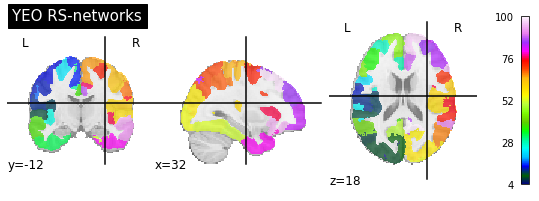

In [51]:
# load atlas
atlas_S = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)
atlas_filename = atlas_S.maps
# Loading atlas image stored in 'maps'
labels = atlas_S.labels                 
# Loading atlas data stored in 'labels'

network_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default'] #note: different from Raichle 

plotting.plot_roi(atlas_filename, 
                  title = "YEO RS-networks",
                 colorbar = True) 

# store ROIs associated with each network in list + dict (containing indeces + labels)
network_indeces_dict = {}
network_indeces = []

for network in network_names :
    selectt = [list(labels).index(label) for label in labels if network in str(label)] 
    network_indeces.append(selectt)
    network_indeces_dict[network] = selectt

   
print(network_indeces) # contains list of indeces for each network
print(network_indeces_dict) # contains dic with pairs of list of indeces for each networks and network label

### Raichle atlas

In [52]:
# import atlas (here from local directory, make sure to have atlas in a useful location)
atlas_R = pd.read_csv('c:\\Users\\julia\\Desktop\\crashcourse\\raichle_atlas.csv')
atlas_R

region_labels_R = atlas_R['Region']
network_labels_R = atlas_R['Network']

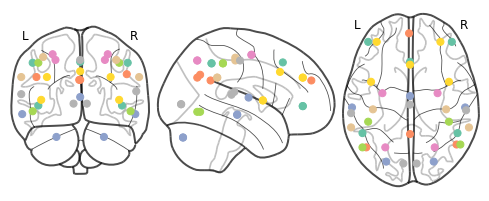

In [53]:
# plot connectdome

node_coords = atlas_R[['MNI_x', 'MNI_y', 'MNI_z']].to_numpy()
labels_R = atlas_R.Region
Networks_R = atlas_R.Network
network_names_R = ["Executive Control", "Default Mode", "Dorsal Attention", "Salience", "Sensorimotor", "Visual", "Auditory"]

adjacency_matrix = np.zeros((len(node_coords), len(node_coords)))
adjacency_matrix.shape
plot_connectome(adjacency_matrix, node_coords)

In [54]:
# store coords associated with each network in list + dict (containing MNI coordinates + labels)

import pandas as pd

df = pd.DataFrame(data = Networks_R)

network_indeces_R = []
network_coords_dict_R = {}

for network in network_names_R :
    select_4 = [list(df.index[df['Network'] == network]) for name in network_names_R if network in str(name)]
    network_indeces_R.append(select_4[0])
    ## network_indeces_dict[network] = select_4             # in case Network:index dictionary is needed, fix this code

print(network_indeces_R)
print(network_coords_dict_R)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9, 10, 11, 12, 13], [14, 15, 16, 17, 18, 19, 20, 21], [22, 23, 24, 25, 26, 27, 28], [29, 30, 31], [32, 33], [34, 35]]
{}


## Define function to compute within- and between functional connectivity (FC)


In [63]:
#### calculate functional connectivity


from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')


def FC_analysis_function(time_series, network_indeces): # potentially also add network_names
    
    # compute matrix of all ROIs
    correlation_matrix_all = correlation_measure.fit_transform([time_series])[0] # fc all rois
    np.fill_diagonal(correlation_matrix_all, 0)


    #### Correlation matrix of all within-network FCs (Raichle)

    ## cleaning up within-network correlations (0s and 1s)

    FC_R = np.zeros([7,7])
    Result = np.zeros([7,7])

    for i, network in enumerate(network_indeces) :
        FC_R = correlation_measure.fit_transform([time_series[:, network]])[0]
       # FC_corrected = np.delete(FC, np.where(FC == 1))

        FC_R = np.tril(FC_R) # remove upper diagonal to remove duplicate values
        print(FC_R)



        FC_corrected = FC_R[FC_R != 1.0] # remove 1s (of same ROI with same ROI)
        FC_corrected = FC_corrected[FC_corrected != 0] # remove 0s to get correct mean
        print(FC_corrected)
        Result[i, i] = FC_corrected.mean()

    ### Calculating complete FC matrix (by adding between-network FC to existing within FC matrix)
    result_2 = np.zeros((7,7))

    # Step 1 within

    result_2 = result_2 +  Result

    # Step 2 between
    for i, network_i in enumerate(network_indeces):
      # i = 0, 1, 2, ..., 6


      for j, network_j in enumerate(network_indeces): 
        # j = 0, 1, 2, ..., 6

        if i == j:
          # compute within network
          continue

        else:
          # compute between network
          connectivity_2 = correlation_matrix_all[network_indeces[i]][:,network_indeces[j]].mean()
        result_2[i, j] = connectivity_2
        
    return correlation_matrix_all, result_2

## loop over subjects and sessions

In [64]:
### define subject and session so that code can be altered for different participants easily

subjects = ['sub-01','sub-99'] # insert subject nr (between sub-01 and sub-40)
sessions = ['ses-pre', 'ses-post'] # insert session type (here ses-pre vs ses-post)
atlases = ['Raichle', 'Schaefer']


## loop over subjects and sessions

all_timeseries = []
all_subjects = []
all_atlases = []
all_sessions = []
all_FC_matrices = []
all_FC_matrices_all_ROIs = []

for subject in subjects:
    for session in sessions:
        for atlas in atlases: 
    
    # confound file (fMRIprep)
            confound_filename = f'{subject}_{session}_task-rest_desc-confounds_timeseries.tsv'
            confound_path = Path(root + f"\\derivatives\\fmriprep\\{subject}\\{session}\\func\\" + confound_filename) # the f together with the curved brackets makes it possible to always select whatever is defined as subject. this makes it easy to create a loop that goes through all subjects
            confound_path

            # scan file (fMRIprep)
            
            scan_filename = f'{subject}_{session}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
            
            
            if subject == 'sub-01' : 
                 scan_filename = f'{subject}_{session}_task-rest_acq-noMB_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
              
            scan_path = Path(root + f"\\derivatives\\fmriprep\\{subject}\\{session}\\func\\" + scan_filename)
            print(scan_path)

            # anat scan (just in case)
            anat_scan_filename = f'{subject}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
            anat_scan_path = Path(root + f"\\derivatives\\fmriprep\\{subject}\\anat\\" + anat_scan_filename)
            anat_scan_path

            # mask (only for Raichle atlas)
            mask_filename = f'{subject}_space-MNI152NLin2009cAsym_dseg.nii.gz'
            mask_path = Path(root + f"\\derivatives\\fmriprep\\{subject}\\anat\\" + mask_filename)

            mask_img = nib.load(mask_path)
            GM_mask = nilearn.masking.compute_brain_mask(mask_img, threshold=0.25 , connected=False, opening=False, memory=None, verbose=0, mask_type='gm')

            # confound regression
            confounds_selected_FC, sample_mask_FC = interfaces.fmriprep.load_confounds(str(scan_path), 
                                                                 strategy=('motion', 'high_pass', 'scrub',
                                                                            'compcor'), 
                                               motion='basic', scrub = 0, fd_threshold= 0.5 , std_dvars_threshold= 1.5 , compcor='anat_combined', 
                                               n_compcor= 5 , ica_aroma='full', demean=True)
            # Compute masker for time series
            if atlas == 'Raichle' :
                masker = NiftiSpheresMasker(node_coords, radius=10, 
                                            detrend=True, standardize=True, allow_overlap = True,
                                            low_pass=0.09, high_pass=0.01, t_r=2.5,
                                            memory='nilearn_cache', memory_level=1, verbose=2, mask_img = GM_mask)
            elif atlas == 'Schaefer' :
                masker = NiftiLabelsMasker(labels_img=atlas_filename, t_r = 2.5, 
                                   low_pass = 0.09, smoothing_fwhm = 6, standardize=True)

            # extract time series
            time_series = masker.fit_transform(str(scan_path), sample_mask = sample_mask_FC, # considering confounds + outliers
                                       confounds= confounds_selected_FC)

            
            ## Functional connectivity analysis
            
            # specify network and network indeces
            if atlas == 'Raichle' :
                network_indeces = network_indeces_R
                network_names = network_names_R
                
            # call function
            FC_matrix_all_ROIs, FC_matrix = FC_analysis_function(time_series, network_indeces)
            
            all_timeseries.append(time_series)
            all_subjects.append(subject)
            all_sessions.append(session)
            all_atlases.append(atlas)
            all_FC_matrices.append(FC_matrix)
            all_FC_matrices_all_ROIs.append(FC_matrix_all_ROIs)

DF = pd.DataFrame({"sub":all_subjects,"ses":all_sessions,"atlas":all_atlases,"TS":all_timeseries, "FC_net":all_FC_matrices, "FC_ROIs":all_FC_matrices_all_ROIs})
### this resulting dataframe contains all variables needed for plotting or further analysis



c:\Users\julia\Desktop\Leiden first year\Internship_Synthesis\Data\Pilot data\Pilot_data_BIDS\derivatives\fmriprep\sub-01\ses-pre\func\sub-01_ses-pre_task-rest_acq-noMB_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[Memory]0.0s, 0.0min    : Loading _filter_and_extract...
[[1.         0.         0.         0.         0.        ]
 [0.5275603  1.         0.         0.         0.        ]
 [0.4635848  0.5996467  1.         0.         0.        ]
 [0.555178   0.49773198 0.43744192 1.         0.        ]
 [0.3926595  0.11501995 0.46032515 0.45039746 1.        ]]
[0.5275603  0.4635848  0.5996467  0.555178   0.49773198 0.43744192
 0.3926595  0.11501995 0.46032515 0.45039746]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.7031557  1.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.36150938 0.3298677  1.         0.         0.         0.
  0.         0.         0.        ]
 [0.70369834 0.52084374 0.29457

[[ 1.          0.          0.          0.          0.        ]
 [-0.1235919   1.          0.          0.          0.        ]
 [-0.05214898  0.8172342   1.          0.          0.        ]
 [ 0.01602777  0.7390815   0.55648017  1.          0.        ]
 [-0.09283618  0.85808825  0.855342    0.7053976   1.        ]]
[-0.1235919  -0.05214898  0.8172342   0.01602777  0.7390815   0.55648017
 -0.09283618  0.85808825  0.855342    0.7053976 ]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.5906091  1.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.74242693 0.7749127  1.         0.         0.         0.
  0.         0.         0.        ]
 [0.8885507  0.6805153  0.90170664 1.         0.         0.
  0.         0.         0.        ]
 [0.67911494 0.53605044 0.5924332  0.68678695 1.         0.
  0.         0.         0.        ]
 [0.58054423 0.41113302 0.48328117 0.5505672  0.80071527 1.
  0.         0.      

C:\Users\julia\AppData\Local\Temp\ipykernel_5208\3772159928.py:34: RuntimeWarning: Mean of empty slice.
  Result[i, i] = FC_corrected.mean()
C:\Users\julia\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[Memory]0.0s, 0.0min    : Loading _filter_and_extract...
[[1.         0.         0.         0.         0.        ]
 [0.6506301  1.         0.         0.         0.        ]
 [0.55980587 0.5171787  1.         0.         0.        ]
 [0.48240262 0.6855386  0.33360744 1.         0.        ]
 [0.44009417 0.5451513  0.4228909  0.6252629  1.        ]]
[0.6506301  0.55980587 0.5171787  0.48240262 0.6855386  0.33360744
 0.44009417 0.5451513  0.4228909  0.6252629 ]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.48447284 1.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.42122835 0.2530576  1.         0.         0.         0.
  0.         0.         0.        ]
 [0.5990756  0.44588134 0.742689   1.         0.         0.
  0.         0.         0.        ]
 [0.41750965 0.4496141  0.6800471  0.6238587  1.         0.
  0.         0.         0.        ]
 [0.42966393 0.44076255 0.5126305  0.66471106 0.744813   1.

## Preview of dataframe summarizing the results

In [58]:
DF


,sub,ses,atlas,TS,FC_net,FC_ROIs
0,sub-01,ses-pre,Raichle,"[[-0.25622073, 0.20617989, 0.32549062, -0.2529...","[[0.4499545991420746, 0.1498744785785675, 0.30...","[[0.0, 0.52025926, 0.45716918, 0.5474945, 0.38..."
1,sub-01,ses-pre,Schaefer,"[[0.35467947, -0.8552064, -1.6559675, -0.38484...","[[0.6035304665565491, 0.4948981702327728, 0.41...","[[0.0, 0.28799266, 0.4849661, 0.34373087, 0.30..."
2,sub-01,ses-post,Raichle,"[[0.5105525, -0.10332204, 0.04653002, 0.592843...","[[0.3957309424877167, 0.1387631595134735, 0.28...","[[0.0, 0.5033864, 0.3006412, 0.26381123, 0.451..."
3,sub-01,ses-post,Schaefer,"[[-1.6572082, 0.10969305, 0.19679669, -0.48090...","[[0.42790740728378296, 0.47194790840148926, 0....","[[0.0, -0.12355513, -0.052133474, 0.016023016,..."
4,sub-99,ses-pre,Raichle,"[[-0.8386138, 0.86538166, -0.49150527, -0.8770...","[[0.2802143096923828, 0.21262112259864807, 0.2...","[[0.0, 0.29958862, 0.28480417, 0.25544924, 0.2..."
5,sub-99,ses-pre,Schaefer,"[[0.40678364, 1.0051422, 1.2435522, -0.0192179...","[[0.5402491688728333, 0.25620079040527344, 0.2...","[[0.0, 0.37654865, 0.33290336, 0.3489787, 0.29..."
6,sub-99,ses-post,Raichle,"[[-0.06596292, 0.16345663, 0.80683696, 0.62308...","[[0.5262562036514282, 0.3397919833660126, 0.25...","[[0.0, 0.6374032, 0.54842556, 0.47259572, 0.43..."
7,sub-99,ses-post,Schaefer,"[[0.35258025, -1.2426332, 0.9089184, -1.700232...","[[0.3725591003894806, 0.1538725346326828, 0.18...","[[0.0, 0.10201806, 0.24663351, 0.056193978, 0...."


## Plotting of within - and between network FC

<AxesSubplot:title={'center':'Network Functional Connectivity - diff (Raichle)'}>

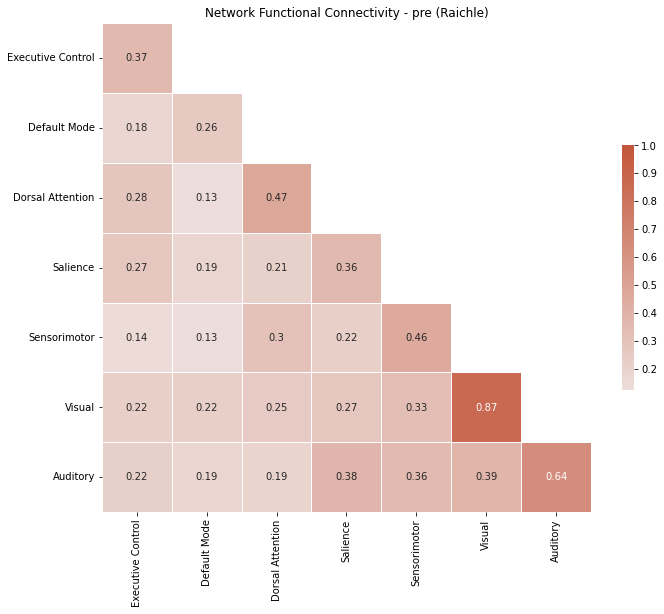

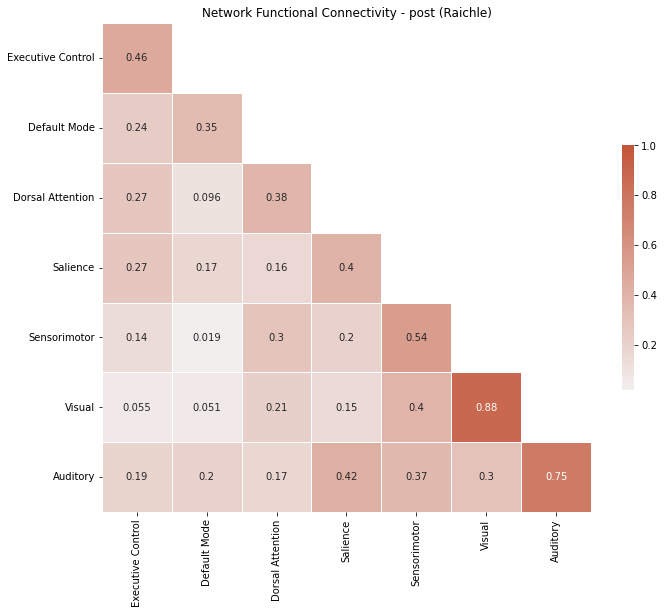

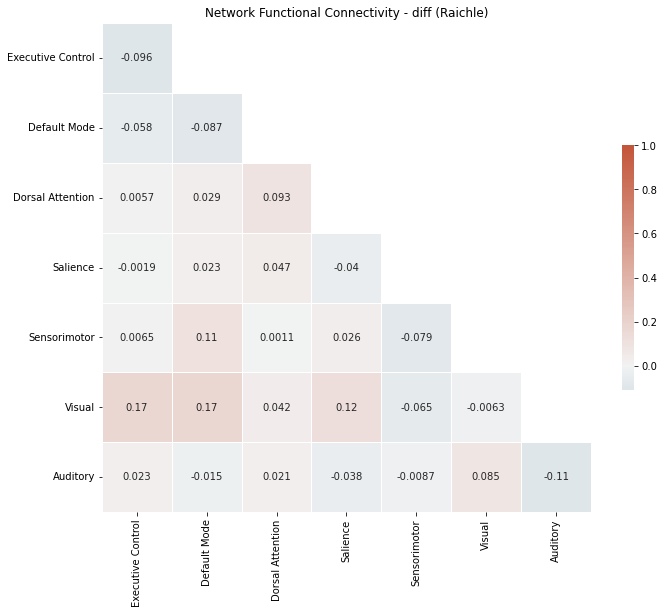

In [134]:
## Extract data + Plot complete FC matrix 
    

    
#### the following code extracts the FC data for all subjects and summarizes the within-and between network FC for pre- and post-session
# The example below uses he Raichle atlas but it can be easily changed to Schaefer in the first line

## filter desired columns from dataframe (FC pre-session)    
FC_Raichle_pre = DF[(DF['atlas'] == 'Raichle') & (DF['ses'] == 'ses-pre')] ### adjust depending on desired atlas

# Calculate the mean of the "FC_net" column for the filtered rows
FC_Raichle_pre = pd.pivot_table(FC_Raichle_pre, values='FC_net', index='sub')

FC_Raichle_pre = np.array([value for value in FC_Raichle_pre.values]).mean(axis = 0)

###
## filter desired columns from dataframe (FC post-session)      
FC_Raichle_post = DF[(DF['atlas'] == 'Raichle') & (DF['ses'] == 'ses-post')]

# Calculate the mean of the "FC_net" column for the filtered rows
FC_Raichle_post = pd.pivot_table(FC_Raichle_post, values='FC_net', index='sub')

FC_Raichle_post = np.array([value for value in FC_Raichle_post.values]).mean(axis = 0)


###
## calculate difference between pre- and post session FC
FC_Raichle_diff = FC_Raichle_pre - FC_Raichle_post

###### Plotting ########

#### plot FC - pre (Raichle)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(FC_Raichle_pre[0], dtype=bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Network Functional Connectivity - pre (Raichle)')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(FC_Raichle_pre[0], mask=mask, cmap=cmap, vmax=1, center=0, annot = True, 
            xticklabels = network_names_R, yticklabels = network_names_R,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### plot FC - post (Raichle)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(FC_Raichle_post[0], dtype=bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Network Functional Connectivity - post (Raichle)')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(FC_Raichle_post[0], mask=mask, cmap=cmap, vmax=1, center=0, annot = True, 
            xticklabels = network_names_R, yticklabels = network_names_R,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### plot FC - diff (Raichle)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(FC_Raichle_diff[0], dtype=bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Network Functional Connectivity - diff (Raichle)')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(FC_Raichle_diff[0], mask=mask, cmap=cmap, vmax=1, center=0, annot = True, 
            xticklabels = network_names_R, yticklabels = network_names_R,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### FC - Schaefer atlas

<AxesSubplot:title={'center':'Network Functional Connectivity - diff (Schaefer)'}>

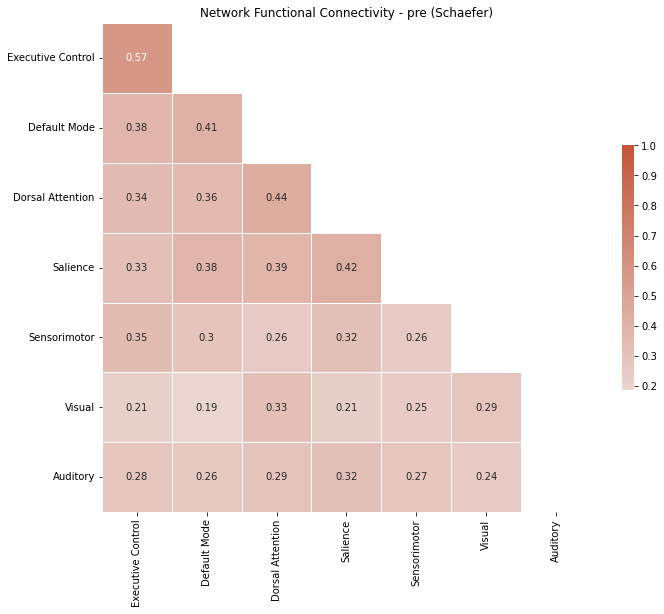

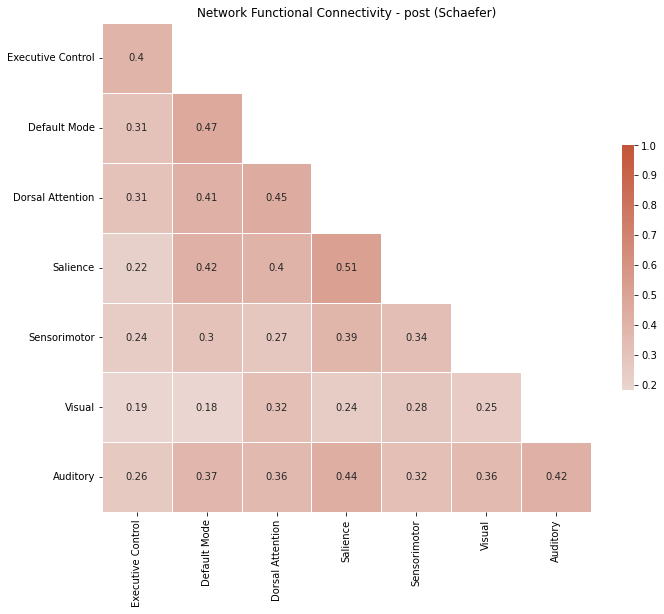

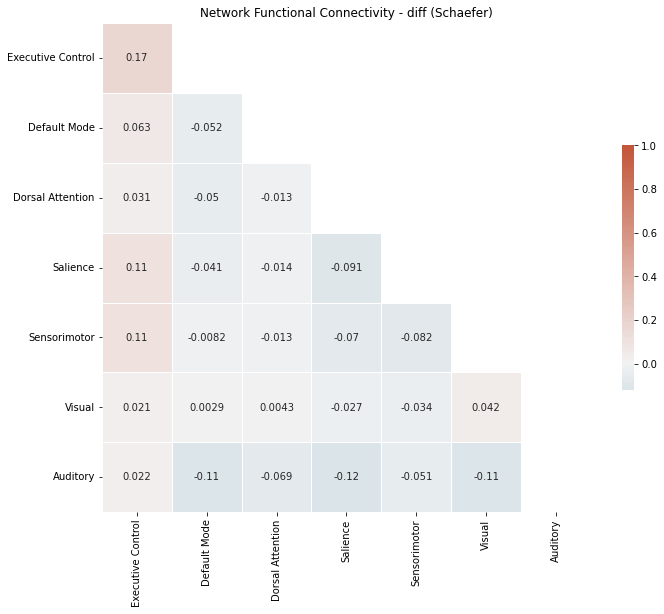

In [136]:
## filter desired columns from dataframe (FC pre-session)    
FC_Schaefer_pre = DF[(DF['atlas'] == 'Schaefer') & (DF['ses'] == 'ses-pre')] ### adjust depending on desired atlas

# Calculate the mean of the "FC_net" column for the filtered rows
FC_Schaefer_pre = pd.pivot_table(FC_Schaefer_pre, values='FC_net', index='sub')

FC_Schaefer_pre = np.array([value for value in FC_Schaefer_pre.values]).mean(axis=0)

###
## filter desired columns from dataframe (FC post-session)      
FC_Schaefer_post = DF[(DF['atlas'] == 'Schaefer') & (DF['ses'] == 'ses-post')]

# Calculate the mean of the "FC_net" column for the filtered rows
FC_Schaefer_post = pd.pivot_table(FC_Schaefer_post, values='FC_net', index='sub')

FC_Schaefer_post = np.array([value for value in FC_Schaefer_post.values]).mean(axis=0)

###
## calculate difference between pre- and post-session FC
FC_Schaefer_diff = FC_Schaefer_pre - FC_Schaefer_post

###### Plotting ########

#### plot FC - pre (Schaefer)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(FC_Schaefer_pre[0], dtype=bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Network Functional Connectivity - pre (Schaefer)')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(FC_Schaefer_pre[0], mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            xticklabels=network_names, yticklabels=network_names,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### plot FC - post (Schaefer)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(FC_Schaefer_post[0], dtype=bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Network Functional Connectivity - post (Schaefer)')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(FC_Schaefer_post[0], mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            xticklabels=network_names, yticklabels=network_names,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### plot FC - diff (Schaefer)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(FC_Schaefer_diff[0], dtype=bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Network Functional Connectivity - diff (Schaefer)')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(FC_Schaefer_diff[0], mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            xticklabels=network_names, yticklabels=network_names,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
